In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

%matplotlib inline 

In [2]:
ames = pd.read_csv('./data/Ames_Housing_Price_Data.csv')
ames = ames.iloc[:,1:]

In [119]:
ames.shape

(2580, 81)

## Feature type check

In [3]:
ames.columns = ames.columns.str.lower()
ames.mssubclass = ames.mssubclass.astype('object')
ames.mosold = ames.mosold.astype('object')

By readling the data dictionaory, a few features come in ordinary scale, such as 'OverallQual' and 'OverallCond'. To decide whether or not to convert these data type, we check the scatter plot of saleprice against these features, to see if there is a linear pattern.

In [4]:
oridinal_col = ['overallqual','overallcond','exterqual','extercond','bsmtqual','bsmtcond','bsmtfintype1',\
                'bsmtfintype2','kitchenqual','fireplacequ','poolqc','garagecond','garagequal']

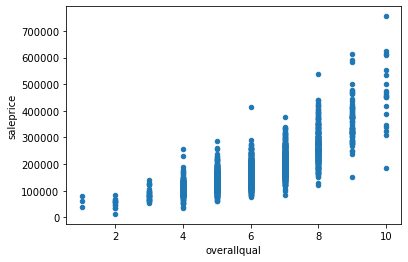

In [5]:
ames[['overallqual','saleprice']].plot(x='overallqual',y='saleprice',kind='scatter')

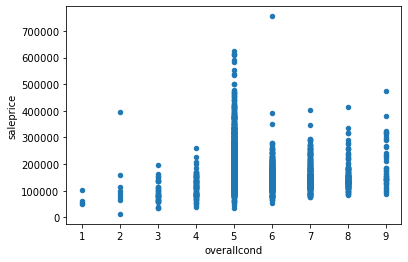

In [6]:
ames[['overallcond','saleprice']].plot(x='overallcond',y='saleprice',kind='scatter')

'overallqual' and 'overallcond' show nearly linear pattern, therefore these 2 columns will be treated as numeric values in the data set. All others will be treated as categorial features.

## Missing Data Cleaning

Missingness: it seems that all the missingness comes from a non-existing feature, therefore all the numeric features were filled with 0 and categorical features with ‘No [feature]’ or similar pattern. 

### Remarks:

*mansvnrtype / masvnrarea: missing because the house is brick? In that case, the price might be different.

*garage: row 433, 531 have garage type but with many missing values in garage specs

*‘Electrical’ : 1 missing data

*When 'Garagetype' is ‘no garage’, the value of 'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond' will have multicollinearity since they will all be coded 0 or ‘No Garage’. For ML purposes, the overall model will include ‘garagetype’ or 'garagearea' only, if significant, the data set will be split in with/without garage for further analysis.

*The same is applied to the basement features group.

In [7]:
ames.loc[ames.lotfrontage.isnull(),'lotfrontage'] = 0
ames.loc[ames.alley.isnull(),'alley'] = 'No Alley'
ames.loc[ames.masvnrtype.isnull(),'masvnrtype'] = 'Missing'
ames.loc[ames.masvnrarea.isnull(),'masvnrarea'] = 0
ames.loc[ames.bsmtqual.isnull(),'bsmtqual'] = 'No Bsmt'
ames.loc[ames.bsmtcond.isnull(),'bsmtcond'] = 'No Bsmt'
ames.loc[ames.bsmtexposure.isnull(),'bsmtexposure'] = 'No Bsmt'
ames.loc[ames.bsmtfintype1.isnull(),'bsmtfintype1'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf1.isnull(),'bsmtfinsf1'] = 0
ames.loc[ames.bsmtfintype2.isnull(),'bsmtfintype2'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf2.isnull(),'bsmtfinsf2'] = 0
ames.loc[ames.bsmtunfsf.isnull(),'bsmtunfsf'] = 0
ames.loc[ames.totalbsmtsf.isnull(),'totalbsmtsf'] = 0
ames.loc[ames.bsmtfullbath.isnull(),'bsmtfullbath'] = 0
ames.loc[ames.bsmthalfbath.isnull(),'bsmthalfbath'] = 0
ames.loc[ames.fireplaces == 0,'fireplacequ'] = 'No Fireplace'
ames.loc[ames.garagetype.isnull(),'garagetype'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garageyrblt'] = 0
ames.loc[ames.garagetype == 'No Garage','garagefinish'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecars'] = 0
ames.loc[ames.garagetype == 'No Garage','garagearea'] = 0
ames.loc[ames.garagetype == 'No Garage','garagequal'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecond'] = 'No Garage'
ames.loc[ames.poolarea == 0,'poolqc'] = 'No Pool'
ames.loc[ames.fence.isnull(),'fence'] = 'No Fence'
ames.loc[ames.miscfeature.isnull(),'miscfeature'] = 'None'

In [8]:
ames.loc[ames.garageyrblt.isnull(),]

pid  grlivarea  saleprice mssubclass mszoning  lotfrontage  \
433  910201180       1828     150909         70       RM         50.0   
531  903426160       1984     160000         60       RM         57.0   

     lotarea street     alley lotshape landcontour utilities lotconfig  \
433     9060   Pave  No Alley      Reg         Lvl    AllPub    Inside   
531     8094   Pave      Grvl      Reg         Lvl    AllPub    Inside   

    landslope neighborhood condition1 condition2 bldgtype housestyle  \
433       Gtl       IDOTRR       Norm       Norm     1Fam     2Story   
531       Gtl      OldTown       Norm       Norm   2fmCon     2.5Unf   

     overallqual  overallcond  yearbuilt  yearremodadd roofstyle roofmatl  \
433            5            6       1923          1999     Gable  CompShg   
531            6            8       1910          1983     Gable  CompShg   

    exterior1st exterior2nd masvnrtype  masvnrarea exterqual extercond  \
433     Wd Sdng     Plywood       None         0.0        TA        TA   
531     Wd Sdng     Wd Sdng       None         0.0        TA        TA   

    foundation bsmtqual bsmtcond bsmtexposure bsmtfintype1  bsmtfinsf1  \
433     BrkTil       Gd       TA           No          ALQ       548.0   
531      PConc       TA       TA           Mn          Rec       196.0   

    bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf heating heatingqc  \
433          Unf         0.0      311.0        859.0    GasA        Ex   
531          Unf         0.0     1046.0       1242.0    GasA        Gd   

    centralair electrical  1stflrsf  2ndflrsf  lowqualfinsf  bsmtfullbath  \
433          Y      SBrkr       942       886             0           0.0   
531          Y      SBrkr      1242       742             0           0.0   

     bsmthalfbath  fullbath  halfbath  bedroomabvgr  kitchenabvgr kitchenqual  \
433           0.0         2         0             3             1          Gd   
531           0.0         2         0             5             1          TA   

     totrmsabvgrd functional  fireplaces   fireplacequ garagetype  \
433             6        Typ           0  No Fireplace     Detchd   
531             8        Typ           0  No Fireplace     Detchd   

     garageyrblt garagefinish  garagecars  garagearea garagequal garagecond  \
433          NaN          NaN         NaN         NaN        NaN        NaN   
531          NaN          NaN         1.0       360.0        NaN        NaN   

    paveddrive  wooddecksf  openporchsf  enclosedporch  3ssnporch  \
433          Y         174            0            212          0   
531          Y          64            0            180          0   

     screenporch  poolarea   poolqc  fence miscfeature  miscval mosold  \
433            0         0  No Pool  MnPrv        None        0      3   
531            0         0  No Pool  MnPrv        Shed     1000      9   

     yrsold saletype salecondition  
433    2007      WD         Alloca  
531    2008      WD         Normal

In [9]:
ames.loc[ames.electrical.isnull(),]

pid  grlivarea  saleprice mssubclass mszoning  lotfrontage  \
2442  916386080       1394     167500         80       RL         73.0   

      lotarea street     alley lotshape landcontour utilities lotconfig  \
2442     9735   Pave  No Alley      Reg         Lvl    AllPub    Inside   

     landslope neighborhood condition1 condition2 bldgtype housestyle  \
2442       Gtl       Timber       Norm       Norm     1Fam       SLvl   

      overallqual  overallcond  yearbuilt  yearremodadd roofstyle roofmatl  \
2442            5            5       2006          2007     Gable  CompShg   

     exterior1st exterior2nd masvnrtype  masvnrarea exterqual extercond  \
2442     VinylSd     VinylSd       None         0.0        TA        TA   

     foundation bsmtqual bsmtcond bsmtexposure bsmtfintype1  bsmtfinsf1  \
2442      PConc       Gd       TA           No          Unf         0.0   

     bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf heating heatingqc  \
2442          Unf         0.0      384.0        384.0    GasA        Gd   

     centralair electrical  1stflrsf  2ndflrsf  lowqualfinsf  bsmtfullbath  \
2442          Y        NaN       754       640             0           0.0   

      bsmthalfbath  fullbath  halfbath  bedroomabvgr  kitchenabvgr  \
2442           0.0         2         1             3             1   

     kitchenqual  totrmsabvgrd functional  fireplaces   fireplacequ  \
2442          Gd             7        Typ           0  No Fireplace   

     garagetype  garageyrblt garagefinish  garagecars  garagearea garagequal  \
2442    BuiltIn       2007.0          Fin         2.0       400.0         TA   

     garagecond paveddrive  wooddecksf  openporchsf  enclosedporch  3ssnporch  \
2442         TA          Y         100            0              0          0   

      screenporch  poolarea   poolqc     fence miscfeature  miscval mosold  \
2442            0         0  No Pool  No Fence        None        0      5   

      yrsold saletype salecondition  
2442    2008      WD         Normal

After major data cleaning, 3 rows are still left with missing values. After checking the 3 records, the missing information cannot be imputed easily with the current information, so these 3 rows were removed. A total of 2577 rows of data will be included in the analysis.

In [10]:
ames2 = ames.dropna(axis=0).copy()
ames2.shape

(2577, 81)

## Adding Features

- 'price_sqft' = 'saleprice' / 'grlivarea'
 
- 'house_age'  = 'yrsold' - 'yearbuilt'
 
- 'reno_age' = 'yrsold' - 'yearremodadd'
 
- bathroom # above ground: 'tbath_abvgr' = 'fullbath' + 'halfbath'*0.5

- bathroom # in basement: 'tbath_bsmt' = 'bsmtfullbath' + 'bsmthalfbath'*0.5
 
- bedroom/bathroom ratio (above ground): 'bbratio_abvgr' = 'bedroomabvgr' / 'tbath_abvgr'
  
There are only two houses that have a bathroom in the basement, with this it will not be possble to calculate the 'bbratio_abvgr' . 

To make sense of the date, the missing data will be imputed.

### Be aware of multicollinearity between the introduced variables

In [11]:
ames2['price_sqft'] = ames2['saleprice'] / ames2['grlivarea']
ames2['house_age'] = ames2['yrsold'] - ames2['yearbuilt']
ames2['reno_age'] = ames2['yrsold'] - ames2['yearremodadd']
ames2.loc[ames2['reno_age']<0,'reno_age'] = 0
ames2['bbratio_abvgr'] = ames2['bedroomabvgr']/(ames2['fullbath'] + ames2['halfbath']*0.5 +\
                                                ames2['bsmtfullbath'] + ames2['bsmthalfbath']*0.5)
ames2.loc[ames2['bbratio_abvgr'].isnull(),'bbratio_abvgr'] = 10
ames2.loc[ames2['bbratio_abvgr']>10,'bbratio_abvgr'] = 10
ames2['tporch'] = ames2['wooddecksf']+ames2['openporchsf']+ames2['enclosedporch']\
                           +ames2['3ssnporch']+ames2['screenporch']

## Check Outliers

Outliers: price higher or lower than 3 std

In [12]:
ames2[['saleprice','price_sqft']].describe()

saleprice   price_sqft
count    2577.000000  2577.000000
mean   178081.264649   120.934759
std     75071.726566    30.637014
min     12789.000000    15.371394
25%    129900.000000   100.401606
50%    159900.000000   119.658120
75%    210000.000000   138.888889
max    755000.000000   276.250881

In [13]:
price_outliers = ames2[((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() > 3) | \
     ((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() < -3)]
outliersp = price_outliers.pid.tolist()
len(price_outliers)

42

In [14]:
price_outliers['saleprice'].mean()

479349.2380952381

The outliers in terms of saleprice are all highly priced houses. We will remove these houses to maintain the assumptions of the regression model.

In [15]:
ames3 = ames2[~ames2['pid'].isin(price_outliers['pid'])]

(array([  4.,  19.,  92., 198., 481., 529., 367., 251., 196., 140.,  86.,
         55.,  50.,  29.,  25.,  15.,  13.,   7.,   8.,   2.,   0.,   3.,
          0.,   2.,   4.,   0.,   0.,   0.,   0.,   1.]),
 array([ 12789.        ,  37529.36666667,  62269.73333333,  87010.1       ,
        111750.46666667, 136490.83333333, 161231.2       , 185971.56666667,
        210711.93333333, 235452.3       , 260192.66666667, 284933.03333333,
        309673.4       , 334413.76666667, 359154.13333333, 383894.5       ,
        408634.86666667, 433375.23333333, 458115.6       , 482855.96666667,
        507596.33333333, 532336.7       , 557077.06666667, 581817.43333333,
        606557.8       , 631298.16666667, 656038.53333333, 680778.9       ,
        705519.26666667, 730259.63333333, 755000.        ]),
 <a list of 30 Patch objects>)

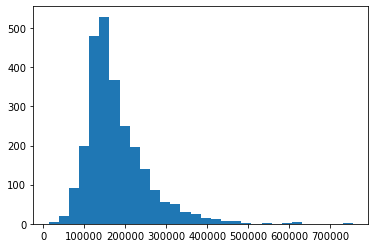

In [16]:
plt.hist(ames2['saleprice'], bins=30)

(array([  1.,   3.,   5.,  23.,  21.,  84.,  85., 158., 261., 308., 270.,
        204., 203., 177., 119., 113.,  86.,  80.,  63.,  56.,  49.,  27.,
         26.,  30.,  25.,  16.,   8.,  12.,  13.,   9.]),
 array([ 12789.        ,  25796.03333333,  38803.06666667,  51810.1       ,
         64817.13333333,  77824.16666667,  90831.2       , 103838.23333333,
        116845.26666667, 129852.3       , 142859.33333333, 155866.36666667,
        168873.4       , 181880.43333333, 194887.46666667, 207894.5       ,
        220901.53333333, 233908.56666667, 246915.6       , 259922.63333333,
        272929.66666667, 285936.7       , 298943.73333333, 311950.76666667,
        324957.8       , 337964.83333333, 350971.86666667, 363978.9       ,
        376985.93333333, 389992.96666667, 403000.        ]),
 <a list of 30 Patch objects>)

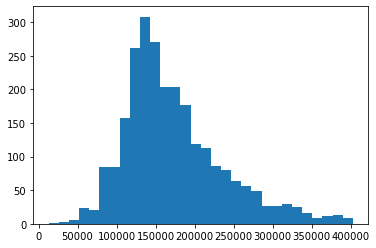

In [17]:
plt.hist(ames3['saleprice'], bins=30)

In [18]:
ames3.shape

(2535, 86)

The distribution of the target variable is less skewed after removing the outliers, however a log transformation may still be desired for a more reliable model.

## Removing Abnormal Sale

By inspecting the data dictionary, there is one type of sales condition called 'Abnormal sale'. Abnormal sales refers to trades, foreclosures, and short sales. These sales may follow a different pricing pattern, which may lessen the descriptive power of the model, therefore they will be excluded.

In [19]:
ames3.groupby('salecondition')[['saleprice']].mean().reset_index()

salecondition      saleprice
0       Abnorml  138218.750000
1       AdjLand  138750.000000
2        Alloca  158719.000000
3        Family  146958.823529
4        Normal  171669.506090
5       Partial  256841.319444

By looking at the average sale price of such salecondition, it is actually lower than all other types. 

In [20]:
ames3 =  ames3[ames3['salecondition'] != 'Abnorml']
ames3.shape

(2475, 86)

## Preparing data set

### Categorical Variables

Creating a list of all categorial variable for future uses.

Check the Boxplots for all categorical variable against price per sqft

In [21]:
factor_col = []
for col in ames3.columns:
    if ames3[col].dtype == 'O':
        factor_col.append(col)

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)

C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl


AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


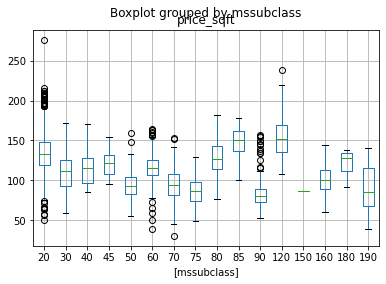

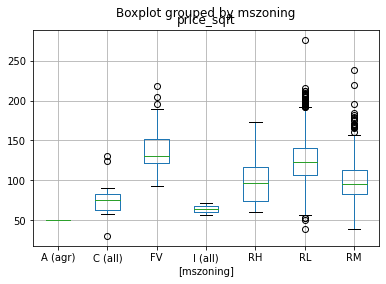

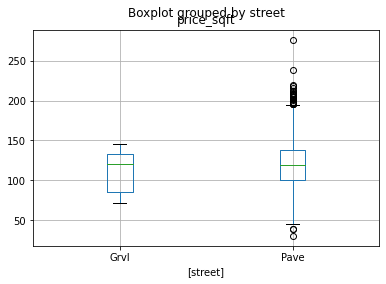

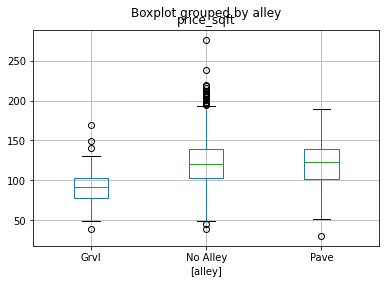

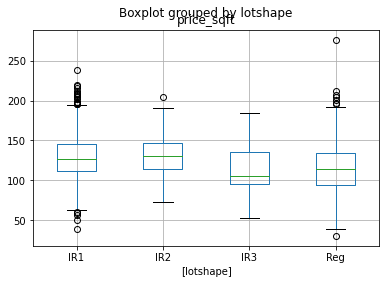

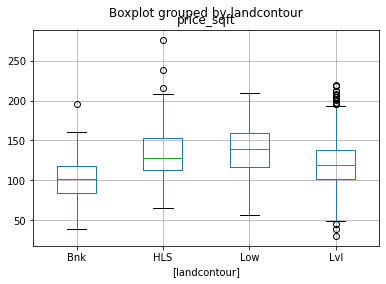

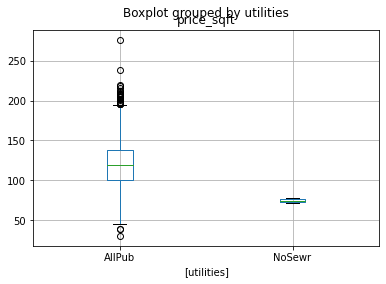

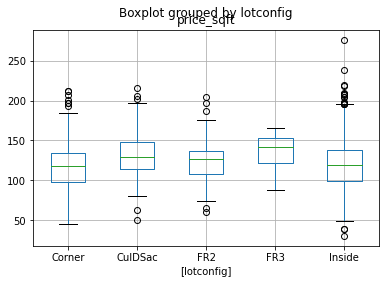

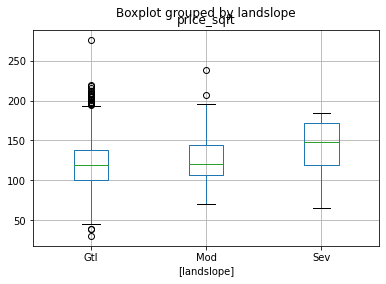

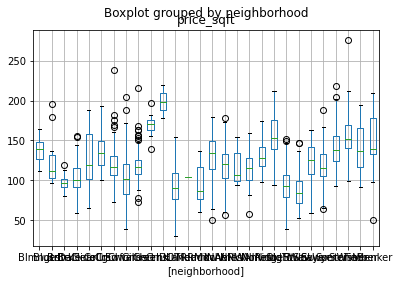

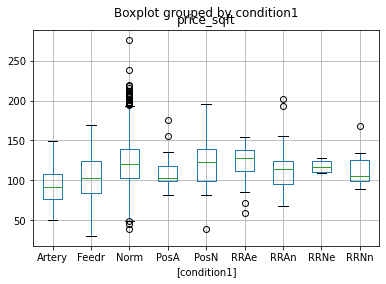

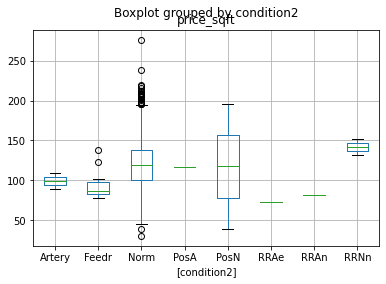

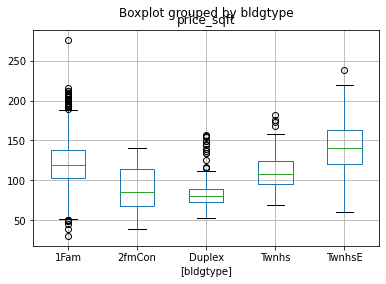

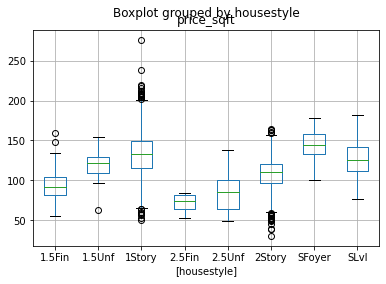

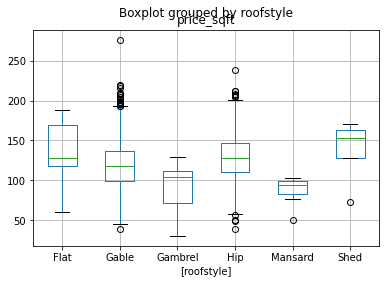

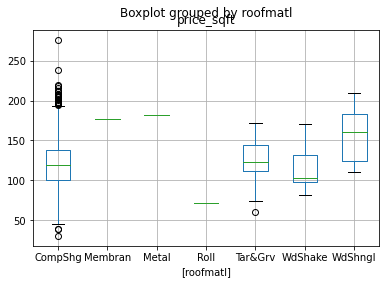

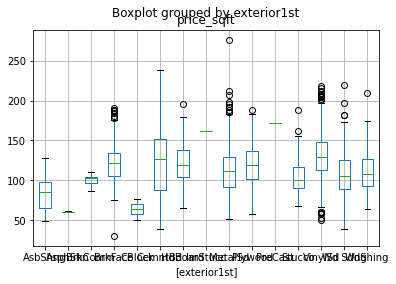

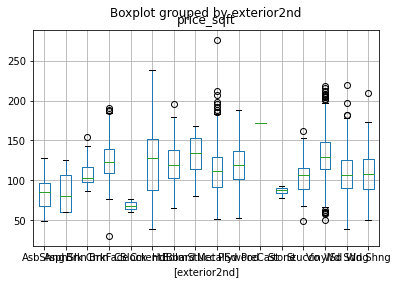

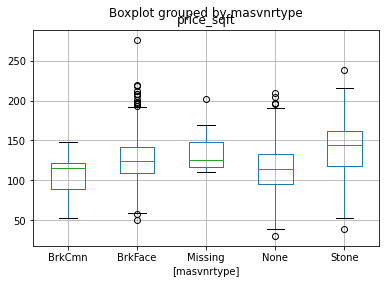

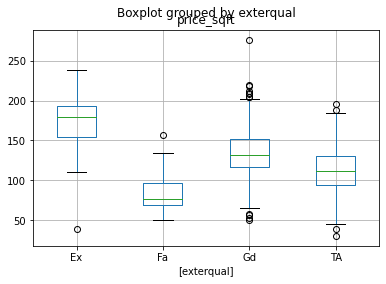

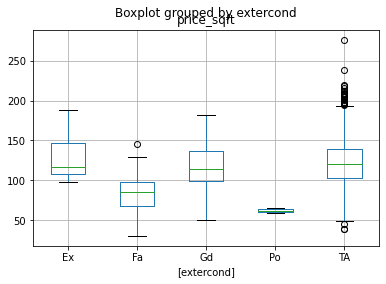

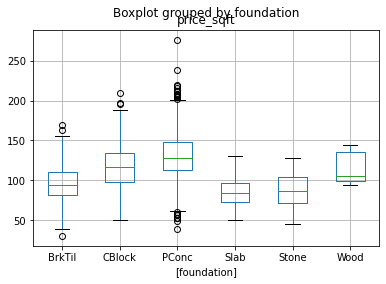

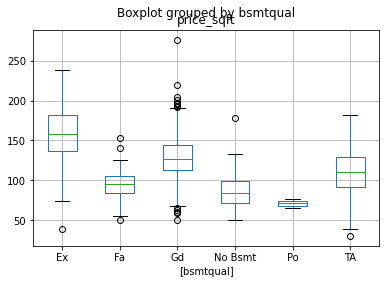

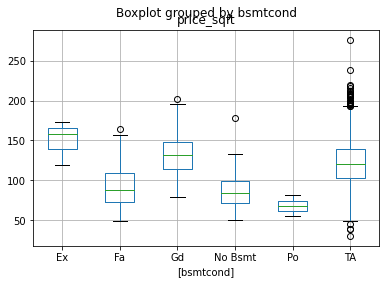

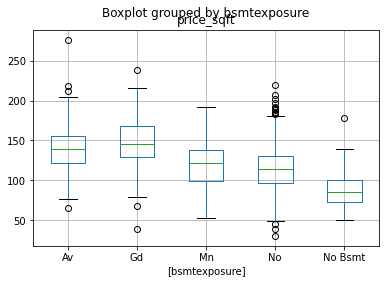

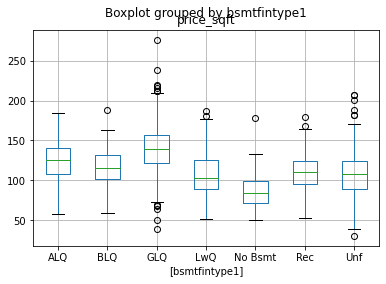

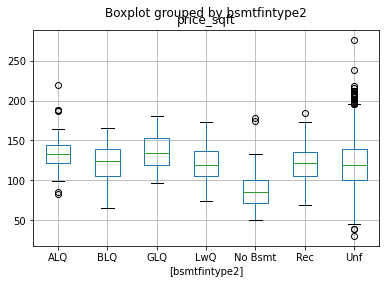

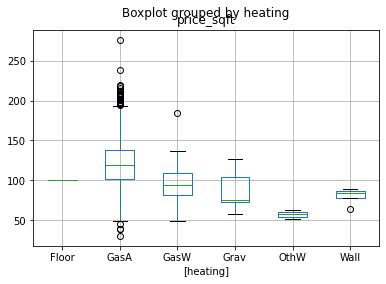

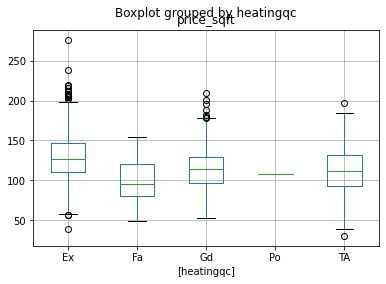

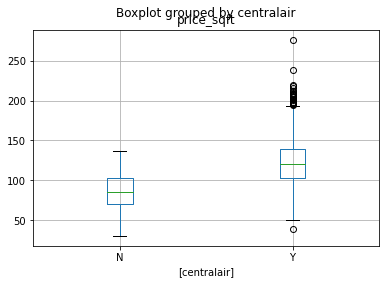

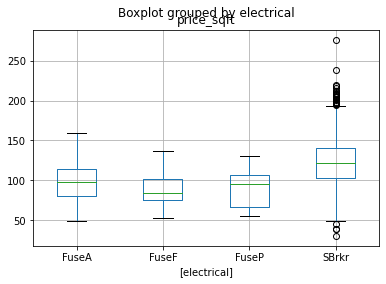

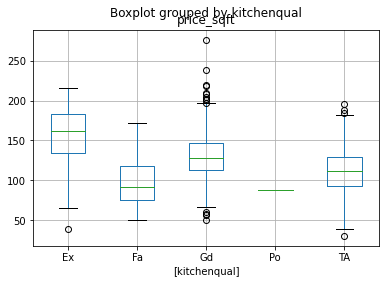

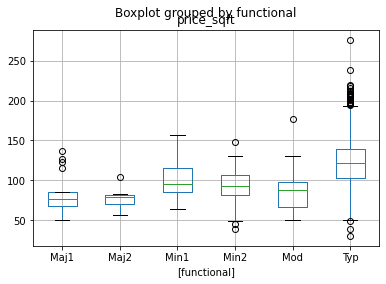

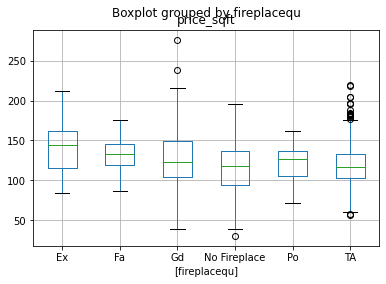

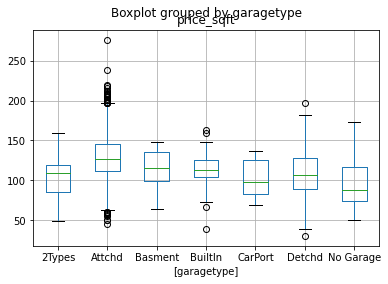

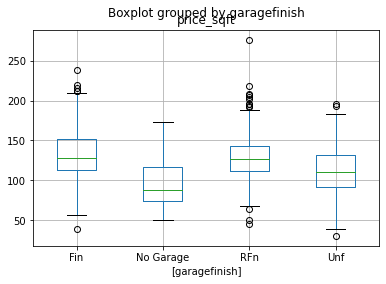

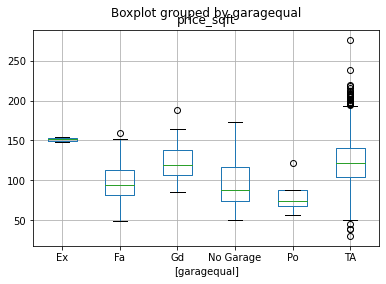

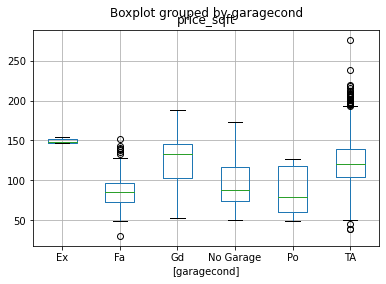

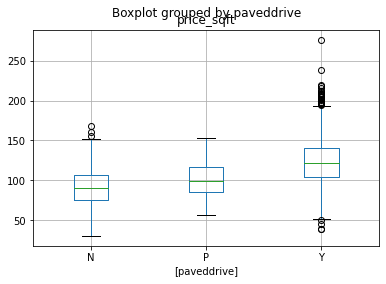

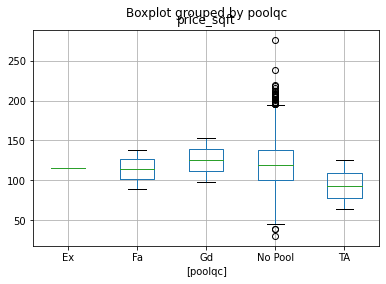

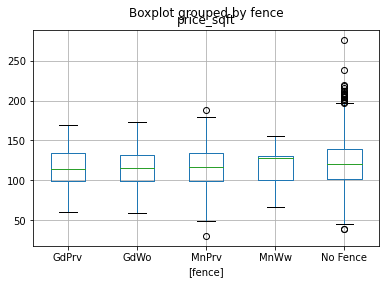

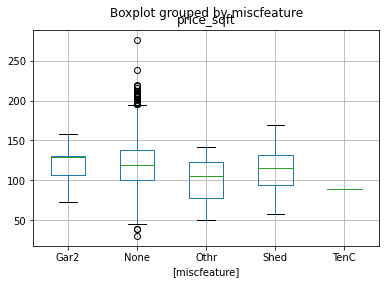

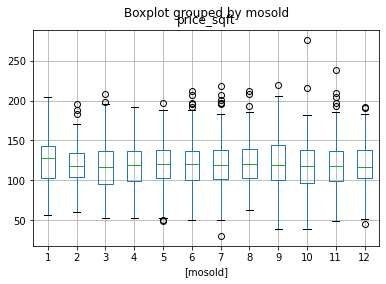

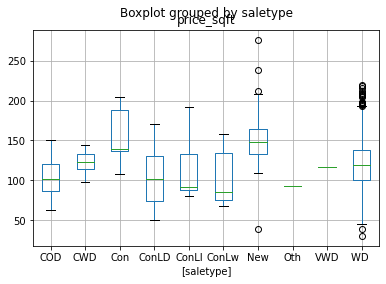

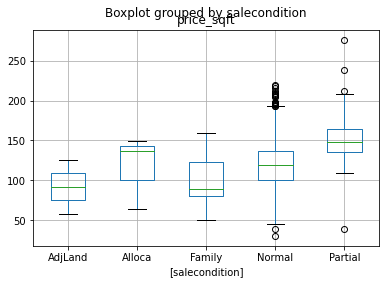

In [22]:
for col in factor_col:
    print(ames3[['price_sqft',col]].boxplot(by = col))

In [23]:
for col in factor_col:
    print(ames3[col].value_counts())

20     892
60     480
50     250
120    168
160    117
30     117
70     112
80     105
90      83
190     50
85      43
75      19
45      17
180     15
40       6
150      1
Name: mssubclass, dtype: int64
RL         1929
RM          399
FV          111
RH           20
C (all)      13
I (all)       2
A (agr)       1
Name: mszoning, dtype: int64
Pave    2465
Grvl      10
Name: street, dtype: int64
No Alley    2315
Grvl          99
Pave          61
Name: alley, dtype: int64
Reg    1578
IR1     820
IR2      64
IR3      13
Name: lotshape, dtype: int64
Lvl    2246
Bnk      92
HLS      86
Low      51
Name: landcontour, dtype: int64
AllPub    2473
NoSewr       2
Name: utilities, dtype: int64
Inside     1816
Corner      418
CulDSac     153
FR2          76
FR3          12
Name: lotconfig, dtype: int64
Gtl    2358
Mod     105
Sev      12
Name: landslope, dtype: int64
NAmes      398
CollgCr    233
OldTown    204
Edwards    160
Gilbert    142
Somerst    138
Sawyer     135
NWAmes     120
SawyerW  

By looking at the boxplots, it seems 'street', 'lotshape', 'loconfig', 'landslope', 'heatingqc', and 'fence' don't have strong influence on the sale price. May consider eliminating these features in the next steps.

Another observation is that many of the features have unbalanced values. This should be taken into consideration if any features are to be included in the model.

### Categorical variables

1. Convert ordinal type of features to int
2. Condense norminal categorical features to decrease the dimensions after dummification

In [24]:
ames3['heatingqc'] = ames3['heatingqc'].replace('Ex',5)
ames3['heatingqc'] = ames3['heatingqc'].replace('Gd',4)
ames3['heatingqc'] = ames3['heatingqc'].replace('TA',3)
ames3['heatingqc'] = ames3['heatingqc'].replace('Fa',2)
ames3['heatingqc'] = ames3['heatingqc'].replace('Po',1)
ames3['extercond'] = ames3['extercond'].replace('Ex',5)
ames3['extercond'] = ames3['extercond'].replace('Gd',4)
ames3['extercond'] = ames3['extercond'].replace('TA',3)
ames3['extercond'] = ames3['extercond'].replace('Fa',2)
ames3['extercond'] = ames3['extercond'].replace('Po',1)
ames3['exterqual'] = ames3['exterqual'].replace('Ex',5)
ames3['exterqual'] = ames3['exterqual'].replace('Gd',4)
ames3['exterqual'] = ames3['exterqual'].replace('TA',3)
ames3['exterqual'] = ames3['exterqual'].replace('Fa',2)
ames3['exterqual'] = ames3['exterqual'].replace('Po',1)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Ex',5)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Gd',4)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('TA',3)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Fa',2)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Po',1)

In [25]:
ames3['mszoning'] = ames3['mszoning'].replace(['A (agr)','C (all)','I (all)','RH','FV'], 'others')
ames3['alley'] = ames3['alley'].replace(['Grvl','Pave'], 'others')
ames3['lotshape'] = ames3['lotshape'].replace(['IR1','IR2','IR3'], 'IR')
ames3['landcontour'] = ames3['landcontour'].replace(['HLS','Bnk','Low'], 'others')
ames3['condition1'] = ames3['condition1'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['condition2'] = ames3['condition2'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['housestyle'] = ames3['housestyle'].replace(['2.5Unf','1.5Unf','2.5Fin'], 'others')
ames3['roofstyle'] = ames3['roofstyle'].replace(['Hip','Gambrel','Flat','Mansard','Shed'], 'others')
ames3['roofmatl'] = ames3['roofmatl'].replace(['Tar&Grv','WdShake','WdShngl','Membran','Roll','Metal'], 'others')
ames3['salecondition'] = ames3['salecondition'].replace(['Family','Alloca','AdjLand'], 'others')
ames3['saletype'] = ames3['saletype'].replace(['ConLw','ConLI','Con','Oth','VWD','CWD','ConLD'], 'others')
ames3['mosold'] = ames3['mosold'].replace([1,2,3], 'QT1')
ames3['mosold'] = ames3['mosold'].replace([4,5,6], 'QT2')
ames3['mosold'] = ames3['mosold'].replace([7,8,9], 'QT3')
ames3['mosold'] = ames3['mosold'].replace([10,11,12], 'QT4')
ames3['miscfeature'] = ames3['miscfeature'].replace(['Shed','Gar2','Othr','TenC'], 'Yes')
ames3['garagecond'] = ames3['garagecond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagecond'] = ames3['garagecond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Fa','Po'], 'Blw_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Fa','Po'], 'Blw_Avg')
ames3['functional'] = ames3['functional'].replace(['Min1','Min2'], 'Min')
ames3['functional'] = ames3['functional'].replace(['Mod','Maj1','Maj2','Sev','Sal'], 'Mod_more')
ames3['electrical'] = ames3['electrical'].replace(['FuseA','FuseF','FuseP','Mix'],'Fuse')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Fa','Po'], 'Blw_Avg')
ames3['exterior1st'] = ames3['exterior1st'].replace(['BrkComm','AsphShn','CBlock','PreCast','ImStucc','AsbShng'],'Others')
ames3['foundation'] = ames3['foundation'].replace(['Slab','Stone','Wood'],'Others')
ames3['heating'] = ames3['heating'].replace(['GasW','Grav','Wall','OthW','Floor'],'Others')
ames3['garagetype'] = ames3['garagetype'].replace(['Basment','2Types','CarPort'],'Others')

### Neighborhood Analysis

Based on our separate analysis on neighborhood, we will use two different way to regroup the neighborhood feature, to see if it will improve the performance of our model.

### 1. Based on Lon-Lat coordinates

In [ ]:
neighbor = pd.read_csv('./data/df_nbhd_grp1.csv')
nbgroup = neighbor[['PID','nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']]
merged = pd.merge(ames3,nbgroup, left_on = 'pid', right_on = 'PID', how='inner')
merged = merged[~merged.duplicated()].drop('PID',axis=1)
merged['neighborhood'] = merged[['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']].idxmax(axis=1)
merged = merged.drop(['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west'],axis=1)

### 2. Based on distant to major employer in Ames - Used in the final model

In [27]:
neighbor2 = pd.read_csv('./data/df_nbhd_distgrp.csv')
nbgroup2 = neighbor2[['pid','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']]
merged = pd.merge(ames3,nbgroup2, on = 'pid',how='inner')
merged = merged[~merged.duplicated()]
merged.drop(columns='neighborhood',inplace=True)

## *Data Analysis Data Set*

In [28]:
merged.head()

pid  grlivarea  saleprice mssubclass mszoning  lotfrontage  lotarea  \
0  909176150        856     126000         30       RL          0.0     7890   
1  905476230       1049     139500        120       RL         42.0     4235   
3  911128020       1001     124900         30   others         60.0     6060   
4  535377150       1039     114000         70       RL         80.0     8146   
5  534177230       1665     227000         60       RL         70.0     8400   

  street     alley lotshape landcontour utilities lotconfig landslope  \
0   Pave  No Alley      Reg         Lvl    AllPub    Corner       Gtl   
1   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl   
3   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl   
4   Pave  No Alley      Reg         Lvl    AllPub    Corner       Gtl   
5   Pave  No Alley      Reg         Lvl    AllPub    Inside       Gtl   

  condition1 condition2 bldgtype housestyle  overallqual  overallcond  \
0       Norm       Norm     1Fam     1Story            6            6   
1       Norm       Norm   TwnhsE     1Story            5            5   
3       Norm       Norm     1Fam     1Story            5            9   
4       Norm       Norm     1Fam     2Story            4            8   
5       Norm       Norm     1Fam     2Story            8            6   

   yearbuilt  yearremodadd roofstyle roofmatl exterior1st exterior2nd  \
0       1939          1950     Gable  CompShg     Wd Sdng     Wd Sdng   
1       1984          1984     Gable  CompShg     HdBoard     HdBoard   
3       1930          2007    others  CompShg     MetalSd     MetalSd   
4       1900          2003     Gable  CompShg     MetalSd     MetalSd   
5       2001          2001     Gable  CompShg     VinylSd     VinylSd   

  masvnrtype  masvnrarea  exterqual  extercond foundation bsmtqual bsmtcond  \
0       None         0.0          3          3     CBlock       TA       TA   
1    BrkFace       149.0          4          3     CBlock  Abv_Avg       TA   
3       None         0.0          4          3     BrkTil       TA       TA   
4       None         0.0          4          4     BrkTil  Blw_Avg       TA   
5       None         0.0          4          3      PConc  Abv_Avg       TA   

  bsmtexposure bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  \
0           No          Rec       238.0          Unf         0.0      618.0   
1           Mn          GLQ       552.0          ALQ       393.0      104.0   
3           No          ALQ       737.0          Unf         0.0      100.0   
4           No          Unf         0.0          Unf         0.0      405.0   
5           No          GLQ       643.0          Unf         0.0      167.0   

   totalbsmtsf heating  heatingqc centralair electrical  1stflrsf  2ndflrsf  \
0        856.0    GasA          3          Y      SBrkr       856         0   
1       1049.0    GasA          3          Y      SBrkr      1049         0   
3        837.0    GasA          5          Y      SBrkr      1001         0   
4        405.0    GasA          4          Y      SBrkr       717       322   
5        810.0    GasA          5          Y      SBrkr       810       855   

   lowqualfinsf  bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  \
0             0           1.0           0.0         1         0             2   
1             0           1.0           0.0         2         0             2   
3             0           0.0           0.0         1         0             2   
4             0           0.0           0.0         1         0             2   
5             0           1.0           0.0         2         1             3   

   kitchenabvgr  kitchenqual  totrmsabvgrd functional  fireplaces  \
0             1            3             4        Typ           1   
1             1            4             5        Typ           0   
3             1            4             5        Typ           0   
4             1        

In [138]:
merged.saleprice.median()

159500.0

### Standardize Numeric Variables & Dummify Variables

Standardize all the numeric variables for better comparability for the beta coefficients.
The target variable 'saleprice' will be taking log transformation.

In [30]:
merged1 = merged.copy()

for col in merged1.columns:
    if col in ['pid','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']:
        continue
        
    elif col == 'saleprice':
        merged1['saleprice'] = np.log10(merged1['saleprice'])
        
    elif col == 'mssubclass':
        col_df = pd.get_dummies(merged1[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged1[col].mode()[0]),axis=1)
        merged1 = pd.concat([merged1, col_df], join='inner',axis=1)
        merged1.drop(col, axis=1, inplace=True)
        
    elif merged1[col].dtype != 'O': 
        merged1[col] = (merged1[col] - merged1[col].mean()) / merged1[col].std()
        
    else:
        col_df = pd.get_dummies(merged1[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged1[col].mode()[0]),axis=1)
        merged1 = pd.concat([merged1, col_df], join='inner',axis=1)
        merged1.drop(col, axis=1, inplace=True)
    
merged1.head()

pid  grlivarea  saleprice  lotfrontage   lotarea  overallqual  \
0  909176150  -1.321797   5.100371    -1.670999 -0.257147    -0.013472   
1  905476230  -0.905927   5.144574    -0.407836 -0.706108    -0.782611   
3  911128020  -1.009355   5.096562     0.133520 -0.481935    -0.782611   
4  535377150  -0.927474   5.056905     0.735026 -0.225702    -1.551750   
5  534177230   0.421410   5.356026     0.434273 -0.194502     1.524807   

   overallcond  yearbuilt  yearremodadd  masvnrarea  exterqual  extercond  \
0     0.331021  -1.059906     -1.648563   -0.565983  -0.663647  -0.251528   
1    -0.566943   0.466115      0.016014    0.353362   1.196231  -0.251528   
3     3.024913  -1.365111      1.142051   -0.565983   1.196231  -0.251528   
4     2.126949  -2.382459      0.946218   -0.565983   1.196231   2.433256   
5     0.331021   1.042612      0.848302   -0.565983   1.196231  -0.251528   

   bsmtfinsf1  bsmtfinsf2  bsmtunfsf  totalbsmtsf  heatingqc  1stflrsf  \
0   -0.468331   -0.306176   0.183398    -0.424220  -1.187998 -0.773712   
1    0.299072    1.963330  -1.025400     0.067036  -1.187998 -0.228849   
3    0.751204   -0.306176  -1.034807    -0.472582   0.906462 -0.364359   
4   -1.049993   -0.306176  -0.317524    -1.572180  -0.140768 -1.166126   
5    0.521472   -0.306176  -0.877240    -0.541307   0.906462 -0.903575   

   2ndflrsf  lowqualfinsf  bsmtfullbath  bsmthalfbath  fullbath  halfbath  \
0 -0.799040     -0.095055      1.115682     -0.254234 -1.006807 -0.753530   
1 -0.799040     -0.095055      1.115682     -0.254234  0.843276 -0.753530   
3 -0.799040     -0.095055     -0.829630     -0.254234 -1.006807 -0.753530   
4 -0.031432     -0.095055     -0.829630     -0.254234 -1.006807 -0.753530   
5  1.239174     -0.095055      1.115682     -0.254234  0.843276  1.248544   

   bedroomabvgr  kitchenabvgr  kitchenqual  totrmsabvgrd  fireplaces  \
0     -1.046989     -0.198767    -0.741857     -1.567721    0.631364   
1     -1.046989     -0.198767     0.867029     -0.900923   -0.931135   
3     -1.046989     -0.198767     0.867029     -0.900923   -0.931135   
4     -1.046989     -0.198767    -0.741857     -0.234126   -0.931135   
5      0.186980     -0.198767     0.867029     -0.234126   -0.931135   

   garageyrblt  garagecars  garagearea  wooddecksf  openporchsf  \
0     0.136436    0.363424   -0.313564   -0.740003    -0.703450   
1     0.242243   -1.015564   -0.973524   -0.740003     0.920310   
3     0.115274   -1.015564   -1.221629    0.471896    -0.703450   
4     0.138787   -1.015564   -0.899093   -0.740003    -0.703450   
5     0.282214    0.363424    0.326547   -0.740003    -0.007553   

   enclosedporch  3ssnporch  screenporch  poolarea   miscval    yrsold  \
0      -0.357959  -0.101803     2.700869 -0.054509 -0.099465  1.644763   
1      -0.357959  -0.101803    -0.279143 -0.054509 -0.099465  0.881023   
3       0.298589   3.215634    -0.279143 -0.054509 -0.099465 -0.646457   
4       2.268230  -0.101803     1.713516 -0.054509 -0.099465  0.881023   
5      -0.357959  -0.101803    -0.279143 -0.054509 -0.099465  0.881023   

   price_sqft  house_age  reno_age  bbratio_abvgr    tporch  nbhd_above_uoi  \
0    0.928655   1.132731  1.758026      -0.710375 -0.092937               0   
1    0.437003  -0.426918  0.040517      -1.217411 -0.480952               0   
3    0.153043   1.336163 -1.186276       0.810730  0.644929               0   
4   -0.367732   2.421136 -0.891846       0.810730  0.625846               0   
5    0.552977  -1.003310 -0.793702      -0.927676 -0.862606               1   

   nbhd_below_uoi  nbhd_above_dot  nbhd_below_dot  mssubclass_30  ...  \
0               1               0               1              1  ...   
1               1               0               1              0  ...   
3               1               0               1              1  ...   
4               1               0               1              0  ...   
5               0               1               0              0  ...   

In [157]:
(merged['fullbath']+merged['halfbath']*0.5).mean()

1.7323828920570266

(array([  1.,   2.,   0.,   0.,   2.,   3.,   8.,  11.,   5.,  17.,  40.,
         43.,  53.,  69., 123., 199., 257., 259., 211., 207., 214., 146.,
        140., 120.,  94.,  84.,  51.,  44.,  22.,  30.]),
 array([4.54406804, 4.57944261, 4.61481718, 4.65019174, 4.68556631,
        4.72094088, 4.75631544, 4.79169001, 4.82706458, 4.86243914,
        4.89781371, 4.93318828, 4.96856285, 5.00393741, 5.03931198,
        5.07468655, 5.11006111, 5.14543568, 5.18081025, 5.21618481,
        5.25155938, 5.28693395, 5.32230851, 5.35768308, 5.39305765,
        5.42843221, 5.46380678, 5.49918135, 5.53455591, 5.56993048,
        5.60530505]),
 <a list of 30 Patch objects>)

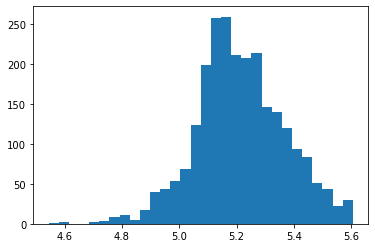

In [31]:
plt.hist(merged1['saleprice'], bins=30)

Target feature is less skewed after log transformation.

## Modeling Data Set

In [32]:
merged1.head()

pid  grlivarea  saleprice  lotfrontage   lotarea  overallqual  \
0  909176150  -1.321797   5.100371    -1.670999 -0.257147    -0.013472   
1  905476230  -0.905927   5.144574    -0.407836 -0.706108    -0.782611   
3  911128020  -1.009355   5.096562     0.133520 -0.481935    -0.782611   
4  535377150  -0.927474   5.056905     0.735026 -0.225702    -1.551750   
5  534177230   0.421410   5.356026     0.434273 -0.194502     1.524807   

   overallcond  yearbuilt  yearremodadd  masvnrarea  exterqual  extercond  \
0     0.331021  -1.059906     -1.648563   -0.565983  -0.663647  -0.251528   
1    -0.566943   0.466115      0.016014    0.353362   1.196231  -0.251528   
3     3.024913  -1.365111      1.142051   -0.565983   1.196231  -0.251528   
4     2.126949  -2.382459      0.946218   -0.565983   1.196231   2.433256   
5     0.331021   1.042612      0.848302   -0.565983   1.196231  -0.251528   

   bsmtfinsf1  bsmtfinsf2  bsmtunfsf  totalbsmtsf  heatingqc  1stflrsf  \
0   -0.468331   -0.306176   0.183398    -0.424220  -1.187998 -0.773712   
1    0.299072    1.963330  -1.025400     0.067036  -1.187998 -0.228849   
3    0.751204   -0.306176  -1.034807    -0.472582   0.906462 -0.364359   
4   -1.049993   -0.306176  -0.317524    -1.572180  -0.140768 -1.166126   
5    0.521472   -0.306176  -0.877240    -0.541307   0.906462 -0.903575   

   2ndflrsf  lowqualfinsf  bsmtfullbath  bsmthalfbath  fullbath  halfbath  \
0 -0.799040     -0.095055      1.115682     -0.254234 -1.006807 -0.753530   
1 -0.799040     -0.095055      1.115682     -0.254234  0.843276 -0.753530   
3 -0.799040     -0.095055     -0.829630     -0.254234 -1.006807 -0.753530   
4 -0.031432     -0.095055     -0.829630     -0.254234 -1.006807 -0.753530   
5  1.239174     -0.095055      1.115682     -0.254234  0.843276  1.248544   

   bedroomabvgr  kitchenabvgr  kitchenqual  totrmsabvgrd  fireplaces  \
0     -1.046989     -0.198767    -0.741857     -1.567721    0.631364   
1     -1.046989     -0.198767     0.867029     -0.900923   -0.931135   
3     -1.046989     -0.198767     0.867029     -0.900923   -0.931135   
4     -1.046989     -0.198767    -0.741857     -0.234126   -0.931135   
5      0.186980     -0.198767     0.867029     -0.234126   -0.931135   

   garageyrblt  garagecars  garagearea  wooddecksf  openporchsf  \
0     0.136436    0.363424   -0.313564   -0.740003    -0.703450   
1     0.242243   -1.015564   -0.973524   -0.740003     0.920310   
3     0.115274   -1.015564   -1.221629    0.471896    -0.703450   
4     0.138787   -1.015564   -0.899093   -0.740003    -0.703450   
5     0.282214    0.363424    0.326547   -0.740003    -0.007553   

   enclosedporch  3ssnporch  screenporch  poolarea   miscval    yrsold  \
0      -0.357959  -0.101803     2.700869 -0.054509 -0.099465  1.644763   
1      -0.357959  -0.101803    -0.279143 -0.054509 -0.099465  0.881023   
3       0.298589   3.215634    -0.279143 -0.054509 -0.099465 -0.646457   
4       2.268230  -0.101803     1.713516 -0.054509 -0.099465  0.881023   
5      -0.357959  -0.101803    -0.279143 -0.054509 -0.099465  0.881023   

   price_sqft  house_age  reno_age  bbratio_abvgr    tporch  nbhd_above_uoi  \
0    0.928655   1.132731  1.758026      -0.710375 -0.092937               0   
1    0.437003  -0.426918  0.040517      -1.217411 -0.480952               0   
3    0.153043   1.336163 -1.186276       0.810730  0.644929               0   
4   -0.367732   2.421136 -0.891846       0.810730  0.625846               0   
5    0.552977  -1.003310 -0.793702      -0.927676 -0.862606               1   

   nbhd_below_uoi  nbhd_above_dot  nbhd_below_dot  mssubclass_30  ...  \
0               1               0               1              1  ...   
1               1               0               1              0  ...   
3               1               0               1              1  ...   
4               1               0               1              0  ...   
5               0               1               0              0  ...   

In [120]:
merged1.shape

(2455, 183)

## Lasso Model

### Lasso Cross Validation: Model with grouping 2

In [35]:
features = ['grlivarea','lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd','masvnrarea',
             'exterqual','extercond','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','heatingqc','1stflrsf',
             '2ndflrsf','lowqualfinsf','bsmtfullbath','bsmthalfbath','fullbath','halfbath','bedroomabvgr','kitchenabvgr',
             'kitchenqual','totrmsabvgrd','fireplaces','garageyrblt','garagecars','garagearea','wooddecksf','openporchsf',
             'enclosedporch','3ssnporch','screenporch','poolarea','miscval','yrsold','house_age','reno_age','bbratio_abvgr',
             'tporch','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot','mssubclass_30','mssubclass_40',
             'mssubclass_45','mssubclass_50','mssubclass_60','mssubclass_70','mssubclass_75','mssubclass_80','mssubclass_85',
             'mssubclass_90','mssubclass_120','mssubclass_150','mssubclass_160','mssubclass_180','mssubclass_190','mszoning_RM',
             'mszoning_others','street_Grvl','alley_others','lotshape_IR','landcontour_others','utilities_NoSewr',
             'lotconfig_Corner','lotconfig_CulDSac','lotconfig_FR2','lotconfig_FR3','landslope_Mod','landslope_Sev',
             'condition1_others','condition2_others','bldgtype_2fmCon','bldgtype_Duplex','bldgtype_Twnhs','bldgtype_TwnhsE',
             'housestyle_1.5Fin','housestyle_2Story','housestyle_SFoyer','housestyle_SLvl','housestyle_others',
             'roofstyle_others','roofmatl_others','exterior1st_BrkFace','exterior1st_CemntBd','exterior1st_HdBoard',
             'exterior1st_MetalSd','exterior1st_Others','exterior1st_Plywood','exterior1st_Stucco','exterior1st_Wd Sdng',
             'exterior1st_WdShing','exterior2nd_AsbShng','exterior2nd_AsphShn','exterior2nd_Brk Cmn','exterior2nd_BrkFace',
             'exterior2nd_CBlock','exterior2nd_CmentBd','exterior2nd_HdBoard','exterior2nd_ImStucc','exterior2nd_MetalSd',
             'exterior2nd_Plywood','exterior2nd_PreCast','exterior2nd_Stone','exterior2nd_Stucco','exterior2nd_Wd Sdng',
             'exterior2nd_Wd Shng','masvnrtype_BrkCmn','masvnrtype_BrkFace','masvnrtype_Missing','masvnrtype_Stone',
             'foundation_BrkTil','foundation_Others','foundation_PConc','bsmtqual_Blw_Avg','bsmtqual_No Bsmt','bsmtqual_TA',
             'bsmtcond_Abv_Avg','bsmtcond_Blw_Avg','bsmtcond_No Bsmt','bsmtexposure_Av','bsmtexposure_Gd','bsmtexposure_Mn',
             'bsmtexposure_No Bsmt','bsmtfintype1_ALQ','bsmtfintype1_BLQ','bsmtfintype1_LwQ','bsmtfintype1_No Bsmt',
             'bsmtfintype1_Rec','bsmtfintype1_Unf','bsmtfintype2_ALQ','bsmtfintype2_BLQ','bsmtfintype2_GLQ','bsmtfintype2_LwQ',
             'bsmtfintype2_No Bsmt','bsmtfintype2_Rec','heating_Others','centralair_N','electrical_Fuse','functional_Min',
             'functional_Mod_more','fireplacequ_Abv_Avg','fireplacequ_Blw_Avg','fireplacequ_TA','garagetype_BuiltIn','garagetype_Detchd',
             'garagetype_No Garage','garagetype_Others','garagefinish_Fin','garagefinish_No Garage','garagefinish_RFn',
             'garagequal_Abv_Avg','garagequal_Blw_Avg','garagequal_No Garage','garagecond_Abv_Avg','garagecond_Blw_Avg',
             'garagecond_No Garage','paveddrive_N','paveddrive_P','poolqc_Ex','poolqc_Fa','poolqc_Gd','poolqc_TA',
             'fence_GdPrv','fence_GdWo','fence_MnPrv','fence_MnWw','miscfeature_Yes','mosold_QT1','mosold_QT3','mosold_QT4',
             'saletype_COD','saletype_New','saletype_others','salecondition_Partial','salecondition_others']
X = merged1[features]
target = merged1['saleprice']

In [36]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X, target)) 
    MSE.append(lasso_cv.mse_path_.mean())
    

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18677961155839728, tolerance: 0.004558130538216861
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23397170278974588, tolerance: 0.004589905973936366
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2648588140127903, tolerance: 0.004697277736256464
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005546437142629479, tolerance: 0.004558130538216861
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005638145789854221, tolerance: 0.004558130538216861
  model = cd_fast.enet_coordinate_descent_gram(


In [38]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],6))

0 1e-05 158 0.92695 0.002169
1 1e-05 154 0.92681 0.002159
2 2e-05 149 0.92656 0.002148
3 3e-05 140 0.92618 0.002136
4 4e-05 128 0.92577 0.002125
5 6e-05 123 0.92519 0.002115
6 9e-05 113 0.92443 0.002105
7 0.00013 101 0.92343 0.002098
8 0.00018 89 0.92219 0.002095
9 0.00026 79 0.92032 0.002101
10 0.00038 65 0.91786 0.002122
11 0.00055 51 0.91543 0.00216
12 0.00078 44 0.91245 0.00222
13 0.00113 36 0.90883 0.002288
14 0.00162 32 0.90572 0.002359
15 0.00234 28 0.90212 0.002437
16 0.00336 23 0.89839 0.002517
17 0.00483 22 0.89226 0.002656
18 0.00695 19 0.88537 0.00282
19 0.01 17 0.87251 0.003123


In [39]:
coef_alpha8 = pd.DataFrame({'feature':X.columns, 'coef':coefs_dict[alphaRange[8]]})
coef_alpha8['importance'] = abs(coef_alpha8['coef'])
coef_alpha8[['feature','importance']].loc[coef_alpha8.coef != 0].sort_values(by='importance',ascending=False)

feature    importance
0                grlivarea  4.824077e-02
3              overallqual  3.297252e-02
144    functional_Mod_more  3.155601e-02
75       condition2_others  2.451158e-02
61             mszoning_RM  2.422887e-02
58          mssubclass_160  2.212081e-02
74       condition1_others  2.163028e-02
87     exterior1st_BrkFace  2.122862e-02
4              overallcond  2.025297e-02
78          bldgtype_Twnhs  2.022839e-02
5                yearbuilt  1.999690e-02
179   salecondition_others  1.922760e-02
141           centralair_N  1.634960e-02
46           mssubclass_30  1.608704e-02
13             totalbsmtsf  1.552701e-02
125        bsmtexposure_Gd  1.370222e-02
159     garagecond_Blw_Avg  1.356889e-02
161           paveddrive_N  1.272630e-02
143         functional_Min  1.133978e-02
117       foundation_PConc  1.099540e-02
10              bsmtfinsf1  1.089186e-02
51           mssubclass_70  9.694203e-03
28              garagecars  9.608065e-03
178  salecondition_Partial  9.038411e-03
26              fireplaces  8.942343e-03
72           landslope_Mod  8.839731e-03
145    fireplacequ_Abv_Avg  8.218824e-03
130       bsmtfintype1_LwQ  7.056481e-03
42          nbhd_above_uoi  6.835197e-03
86         roofmatl_others  6.768961e-03
2                  lotarea  6.704031e-03
29              garagearea  6.528463e-03
88     exterior1st_CemntBd  6.423082e-03
23            kitchenabvgr  5.944929e-03
49           mssubclass_50  5.871290e-03
39                reno_age  5.866109e-03
14               heatingqc  5.650535e-03
151      garagetype_Others  5.489540e-03
174             mosold_QT4  5.377831e-03
38               house_age  5.087878e-03
24             kitchenqual  4.626422e-03
44          nbhd_above_dot  4.609735e-03
18            bsmtfullbath  4.514800e-03
25            totrmsabvgrd  4.443686e-03
65             lotshape_IR  4.436783e-03
124        bsmtexposure_Av  4.362165e-03
79         bldgtype_TwnhsE  4.057721e-03
69       lotconfig_CulDSac  3.789910e-03
50           mssubclass_60  3.690908e-03
173             mosold_QT3  3.307129e-03
34             screenporch  3.279430e-03
8                exterqual  3.240577e-03
133       bsmtfintype1_Unf  3.197223e-03
41                  tporch  3.195254e-03
135       bsmtfintype2_BLQ  3.071830e-03
92     exterior1st_Plywood  2.971081e-03
17            lowqualfinsf  2.845158e-03
1              lotfrontage  2.590241e-03
121       bsmtcond_Abv_Avg  2.579491e-03
11              bsmtfinsf2  2.485225e-03
132       bsmtfintype1_Rec  2.391190e-03
105    exterior2nd_Plywood  2.296244e-03
40           bbratio_abvgr  2.235267e-03
32           enclosedporch  2.185108e-03
20                fullbath  2.099955e-03
148     garagetype_BuiltIn  2.072896e-03
15                1stflrsf  2.004665e-03
22            bedroomabvgr  1.983777e-03
27             garageyrblt  1.764000e-03
154       garagefinish_RFn  1.527226e-03
21                halfbath  1.386203e-03
90     exterior1st_MetalSd  1.351507e-03
54           mssubclass_85  1.349817e-03
169            fence_MnPrv  1.293836e-03
126        bsmtexposure_Mn  1.195851e-03
96     exterior2nd_AsbShng  1.164220e-03
7               masvnrarea  1.092609e-03
70           lotconfig_FR2  1.070747e-03
9                extercond  9.995864e-04
33               3ssnporch  8.546442e-04
139       bsmtfintype2_Rec  8.298654e-04
66      landcontour_others  6.980631e-04
152       garagefinish_Fin  4.781214e-04
31             openporchsf  4.758880e-04
89     exterior1st_HdBoard  4.632455e-04
172             mosold_QT1  2.295871e-04
36                 miscval  6.854342e-05
43          nbhd_below_uoi  5.199488e-16
45          nbhd_below_dot  1.612882e-18

In [40]:
picked_feature = coef_alpha8.loc[coef_alpha8.coef != 0,'feature'].tolist()
picked = X[picked_feature]
picked.columns

Index(['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'masvnrarea', 'exterqual', 'extercond', 'bsmtfinsf1',
       'bsmtfinsf2', 'totalbsmtsf', 'heatingqc', '1stflrsf', 'lowqualfinsf',
       'bsmtfullbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'fireplaces', 'garageyrblt',
       'garagecars', 'garagearea', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'miscval', 'house_age', 'reno_age', 'bbratio_abvgr',
       'tporch', 'nbhd_above_uoi', 'nbhd_below_uoi', 'nbhd_above_dot',
       'nbhd_below_dot', 'mssubclass_30', 'mssubclass_50', 'mssubclass_60',
       'mssubclass_70', 'mssubclass_85', 'mssubclass_160', 'mszoning_RM',
       'lotshape_IR', 'landcontour_others', 'lotconfig_CulDSac',
       'lotconfig_FR2', 'landslope_Mod', 'condition1_others',
       'condition2_others', 'bldgtype_Twnhs', 'bldgtype_TwnhsE',
       'roofmatl_others', 'exterior1st_BrkFace', 'exterior1

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(picked.values, i) for i in range(picked.shape[1])]
vif['variable'] = picked.columns

#view VIF for each explanatory variable 

<ipython-input-41-caeea6be36c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['constant'] = 1
C:\Users\Chun\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [42]:
vif[vif['VIF']>5]

VIF        variable
0    12.096858       grlivarea
5   550.634556       yearbuilt
13    7.905374        1stflrsf
16    5.691452        fullbath
18    5.611390    bedroomabvgr
24    6.478603      garagecars
25    5.713872      garagearea
31  545.682602       house_age
33    6.690535   bbratio_abvgr
35         inf  nbhd_above_uoi
36         inf  nbhd_below_uoi
37         inf  nbhd_above_dot
38         inf  nbhd_below_dot
41    5.299461   mssubclass_60

#### Removing yearbuilt, 1stflrsf, fullbath, garagearea, nbhd_above_uoi,nbhd_above_dot

In [43]:
X2 = merged1[['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'masvnrarea', 'exterqual', 'extercond', 'bsmtfinsf1', 
       'bsmtfinsf2', 'totalbsmtsf', 'heatingqc', 'lowqualfinsf',
       'bsmtfullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'fireplaces', 'garageyrblt',
       'garagecars', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'miscval', 'house_age', 'reno_age', 'bbratio_abvgr',
       'tporch',  'nbhd_below_uoi',
       'nbhd_below_dot', 'mssubclass_30', 'mssubclass_50', 'mssubclass_60',
       'mssubclass_70', 'mssubclass_85', 'mssubclass_160', 'mszoning_RM',
       'lotshape_IR', 'landcontour_others', 'lotconfig_CulDSac',
       'lotconfig_FR2', 'landslope_Mod', 'condition1_others',
       'condition2_others', 'bldgtype_Twnhs', 'bldgtype_TwnhsE',
       'roofmatl_others', 'exterior1st_BrkFace', 'exterior1st_CemntBd',
       'exterior1st_HdBoard', 'exterior1st_MetalSd', 'exterior1st_Plywood',
       'exterior2nd_AsbShng', 'exterior2nd_Plywood', 'foundation_PConc',
       'bsmtcond_Abv_Avg', 'bsmtexposure_Av', 'bsmtexposure_Gd',
       'bsmtexposure_Mn', 'bsmtfintype1_LwQ', 'bsmtfintype1_Rec',
       'bsmtfintype1_Unf', 'bsmtfintype2_BLQ', 'bsmtfintype2_Rec',
       'centralair_N', 'functional_Min', 'functional_Mod_more',
       'fireplacequ_Abv_Avg', 'garagetype_BuiltIn', 'garagetype_Others',
       'garagefinish_Fin', 'garagefinish_RFn', 'garagecond_Blw_Avg',
       'paveddrive_N', 'fence_MnPrv', 'mosold_QT1', 'mosold_QT3', 'mosold_QT4',
       'salecondition_Partial', 'salecondition_others']]

In [55]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=3000, tol=0.1)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X2, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X2, target)) 
    MSE.append(lasso_cv.mse_path_.mean())

In [56]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],5))

0 1e-05 83 0.91289 0.00236
1 1e-05 83 0.91291 0.00236
2 2e-05 83 0.91294 0.00236
3 3e-05 82 0.91297 0.00236
4 4e-05 81 0.91659 0.00236
5 6e-05 81 0.91655 0.00235
6 9e-05 80 0.91641 0.00235
7 0.00013 78 0.91609 0.00231
8 0.00018 76 0.91539 0.00226
9 0.00026 69 0.91418 0.00227
10 0.00038 59 0.91417 0.00223
11 0.00055 48 0.91184 0.00227
12 0.00078 42 0.9089 0.00232
13 0.00113 30 0.90667 0.00233
14 0.00162 27 0.90336 0.00241
15 0.00234 25 0.90032 0.00248
16 0.00336 23 0.89708 0.00255
17 0.00483 20 0.89104 0.00271
18 0.00695 18 0.88422 0.00285
19 0.01 15 0.87171 0.00314


In [57]:
coef_alpha9 = pd.DataFrame({'feature':X2.columns, 'coef':coefs_dict[alphaRange[9]]})
coef_alpha9['weight'] = abs(coef_alpha9['coef'])
coef_alpha9['sign'] = coef_alpha9['coef'].mask(coef_alpha9['coef']>0,'P').mask(coef_alpha9['coef']<0,'N')
coef_alpha9[['feature','weight','sign']].loc[coef_alpha9.coef != 0].sort_values(by='weight',ascending=False)

feature    weight sign
0               grlivarea  0.059284    P
3             overallqual  0.037375    P
38         mssubclass_160  0.034875    N
69    functional_Mod_more  0.030614    N
27              house_age  0.027141    N
35          mssubclass_60  0.022817    N
47         bldgtype_Twnhs  0.020676    N
39            mszoning_RM  0.020397    N
45      condition1_others  0.019861    N
4             overallcond  0.017203    P
10            totalbsmtsf  0.016600    P
46      condition2_others  0.015654    N
50    exterior1st_BrkFace  0.013971    P
75     garagecond_Blw_Avg  0.013610    N
21             garagecars  0.013238    P
8              bsmtfinsf1  0.012781    P
11              heatingqc  0.009850    P
44          landslope_Mod  0.009345    P
6               exterqual  0.008983    P
19             fireplaces  0.008934    P
48        bldgtype_TwnhsE  0.008746    N
68         functional_Min  0.008511    N
76           paveddrive_N  0.008119    N
82   salecondition_others  0.008016    N
2                 lotarea  0.007739    P
14               halfbath  0.007426    P
17            kitchenqual  0.007406    P
71     garagetype_BuiltIn  0.007215    N
13           bsmtfullbath  0.006963    P
67           centralair_N  0.006640    N
80             mosold_QT4  0.006572    N
37          mssubclass_85  0.005772    P
16           kitchenabvgr  0.005610    N
62       bsmtfintype1_LwQ  0.005379    N
31         nbhd_below_uoi  0.005315    P
51    exterior1st_CemntBd  0.005233    N
33          mssubclass_30  0.004849    N
60        bsmtexposure_Gd  0.004800    P
20            garageyrblt  0.004556    P
28               reno_age  0.004384    N
59        bsmtexposure_Av  0.003402    P
74       garagefinish_RFn  0.003371    N
25            screenporch  0.003204    P
42      lotconfig_CulDSac  0.003056    P
12           lowqualfinsf  0.002830    N
79             mosold_QT3  0.002626    P
1             lotfrontage  0.002577    P
9              bsmtfinsf2  0.002482    P
70    fireplacequ_Abv_Avg  0.001653    P
73       garagefinish_Fin  0.001637    N
40            lotshape_IR  0.001513    P
30                 tporch  0.001504    P
63       bsmtfintype1_Rec  0.001475    N
58       bsmtcond_Abv_Avg  0.001462    P
61        bsmtexposure_Mn  0.001363    N
24              3ssnporch  0.001187    P
18           totrmsabvgrd  0.001127    N
29          bbratio_abvgr  0.000975    P
15           bedroomabvgr  0.000969    N
81  salecondition_Partial  0.000937    P
7               extercond  0.000902    N
53    exterior1st_MetalSd  0.000828    P
22            openporchsf  0.000823    P
78             mosold_QT1  0.000538    N
54    exterior1st_Plywood  0.000510    N
23          enclosedporch  0.000510    P
5              masvnrarea  0.000489    P
34          mssubclass_50  0.000176    P
43          lotconfig_FR2  0.000082    N

In [61]:
picked_feature2 = coef_alpha9.loc[coef_alpha9.coef != 0,'feature'].tolist()

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X2['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif['variable'] = X2.columns

#view VIF for each explanatory variable 

<ipython-input-62-388de161e562>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['constant'] = 1


In [63]:
vif[vif['VIF']>5]

VIF   variable
0    6.925394  grlivarea
27   8.326999  house_age
83  21.500809   constant

After removing the redundant features, the second model still shows good performance in terms of variance explained.

In [64]:
lasso_cv.set_params(alphas=[alphaRange[9]])  
lasso_cv.fit(X2, target)
lasso_cv.score(X2, target)

0.9141812357139742

In [65]:
X2[picked_feature2].columns.tolist()

['grlivarea',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'masvnrarea',
 'exterqual',
 'extercond',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'totalbsmtsf',
 'heatingqc',
 'lowqualfinsf',
 'bsmtfullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'kitchenqual',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'house_age',
 'reno_age',
 'bbratio_abvgr',
 'tporch',
 'nbhd_below_uoi',
 'mssubclass_30',
 'mssubclass_50',
 'mssubclass_60',
 'mssubclass_85',
 'mssubclass_160',
 'mszoning_RM',
 'lotshape_IR',
 'lotconfig_CulDSac',
 'lotconfig_FR2',
 'landslope_Mod',
 'condition1_others',
 'condition2_others',
 'bldgtype_Twnhs',
 'bldgtype_TwnhsE',
 'exterior1st_BrkFace',
 'exterior1st_CemntBd',
 'exterior1st_MetalSd',
 'exterior1st_Plywood',
 'bsmtcond_Abv_Avg',
 'bsmtexposure_Av',
 'bsmtexposure_Gd',
 'bsmtexposure_Mn',
 'bsmtfintype1_LwQ',
 'bsmtfintype1_Rec',
 'centralair_N',
 'functional_Min',
 'fun

## Check Assumptions

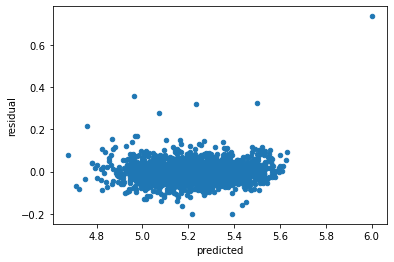

In [66]:
pd.DataFrame({'residual' : (lasso_cv.predict(X2)-target),\
              'predicted' : lasso_cv.predict(X2)}).plot(y='residual',x='predicted',kind='scatter')

In [67]:
predicted_quantile = []
residual_quantile = []
for i in np.linspace(0,1,100):
    predicted_quantile.append((lasso_cv.predict(X2)-target).quantile(i))
    residual_quantile.append(np.quantile(lasso_cv.predict(X2),i))

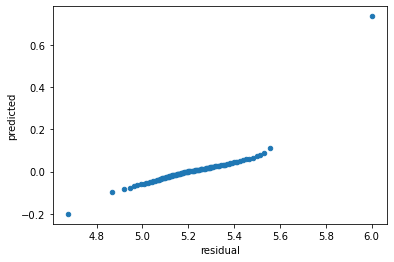

In [68]:
pd.DataFrame({'residual' : residual_quantile,\
              'predicted' : predicted_quantile}).plot(x='residual',y='predicted',kind='scatter')

In [70]:
for i, res in enumerate((lasso_cv.predict(X2)-target).tolist()):
    if res > 0.6:
        print(i)

281


In [71]:
merged.iloc[[281]]

pid  grlivarea  saleprice mssubclass mszoning  lotfrontage  \
287  908154205       4676     184750         60       RL        130.0   

     lotarea street     alley lotshape landcontour utilities lotconfig  \
287    40094   Pave  No Alley       IR      others    AllPub    Inside   

    landslope condition1 condition2 bldgtype housestyle  overallqual  \
287       Gtl     others     others     1Fam     2Story           10   

     overallcond  yearbuilt  yearremodadd roofstyle roofmatl exterior1st  \
287            5       2007          2008    others  CompShg     CemntBd   

    exterior2nd masvnrtype  masvnrarea  exterqual  extercond foundation  \
287     CmentBd      Stone       762.0          5          3      PConc   

    bsmtqual bsmtcond bsmtexposure bsmtfintype1  bsmtfinsf1 bsmtfintype2  \
287  Abv_Avg       TA           Gd          GLQ      2260.0          Unf   

     bsmtfinsf2  bsmtunfsf  totalbsmtsf heating  heatingqc centralair  \
287         0.0      878.0       3138.0    GasA          5          Y   

    electrical  1stflrsf  2ndflrsf  lowqualfinsf  bsmtfullbath  bsmthalfbath  \
287      SBrkr      3138      1538             0           1.0           0.0   

     fullbath  halfbath  bedroomabvgr  kitchenabvgr  kitchenqual  \
287         3         1             3             1            5   

     totrmsabvgrd functional  fireplaces fireplacequ garagetype  garageyrblt  \
287            11        Typ           1     Abv_Avg    BuiltIn       2007.0   

    garagefinish  garagecars  garagearea garagequal garagecond paveddrive  \
287          Fin         3.0       884.0         TA         TA          Y   

     wooddecksf  openporchsf  enclosedporch  3ssnporch  screenporch  poolarea  \
287         208          406              0          0            0         0   

      poolqc     fence miscfeature  miscval mosold  yrsold saletype  \
287  No Pool  No Fence        None        0    QT4    2007      New   

    salecondition  price_sqft  house_age  reno_age  bbratio_abvgr  tporch  \
287       Partial   39.510265          0         0       0.666667     614   

     nbhd_above_uoi  nbhd_below_uoi  nbhd_above_dot  nbhd_below_dot  
287               0               1               0               1

## Data Analysis 

Features have coefficents larger than 0.01: 

'grlivarea', 'overallqual', 'mszoning_RM', 'house_age', 

'totalbsmtsf', 'overallcond', 'condition1_others', 

'bsmtfinsf1', 'garagecars', 'heatingqc', 'fireplaces'.

In [73]:
top_features = merged[['grlivarea', 'overallqual', 'mszoning', 'house_age', \
                       'totalbsmtsf', 'overallcond', 'condition1', \
                       'bsmtfinsf1', 'garagecars', 'heatingqc', 'fireplaces',\
                       'saleprice','price_sqft']]

In [74]:
corr = top_features.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

## Quality-related Features

In [75]:
merged[['overallqual','heatingqc','kitchenqual','exterqual']].corr()

overallqual  heatingqc  kitchenqual  exterqual
overallqual     1.000000   0.427750     0.631422   0.690570
heatingqc       0.427750   1.000000     0.477749   0.494667
kitchenqual     0.631422   0.477749     1.000000   0.679282
exterqual       0.690570   0.494667     0.679282   1.000000

In [76]:
overall = merged1[['overallqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(overall)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     4345.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:04:44   Log-Likelihood:                 2356.2
No. Observations:                2455   AIC:                            -4708.
Df Residuals:                    2453   BIC:                            -4697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2133      0.002   2786.248      

In [77]:
kitchen = merged1[['kitchenqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(kitchen)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1613.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.88e-271
Time:                        14:04:44   Log-Likelihood:                 1725.2
No. Observations:                2455   AIC:                            -3446.
Df Residuals:                    2453   BIC:                            -3435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2133      0.002   2154.734      

In [78]:
heating = merged1[['heatingqc']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(heating)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     663.0
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.30e-129
Time:                        14:04:46   Log-Likelihood:                 1398.7
No. Observations:                2455   AIC:                            -2793.
Df Residuals:                    2453   BIC:                            -2782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2133      0.003   1886.365      0.0

In the final lasso model, the heating quality feature has a higher coefficient than kitchen quality, which indictating when keeps all other factors constant, the heating quality has bigger influence on the saleprice than the kitchen quality. 

However, in single linear regression models, the kitchen quality feature can explain more variance than the heating quality feature. This contradiction suggests that relatively more of the kitchen qulity's explination power is shared with overall quality feature, while the heating system is relatively independent and it contribution unique explaination power to the model. 

In [79]:
Q4 = merged1[['heatingqc','kitchenqual','functional_Min','functional_Mod_more',\
              'fireplacequ_Abv_Avg','fireplacequ_Blw_Avg','fireplacequ_TA','exterqual']]
target_qual = merged[['overallqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(Q4)
ols = sm.OLS(target_qual, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:            overallqual   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     442.6
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:04:49   Log-Likelihood:                -3028.7
No. Observations:                2455   AIC:                             6075.
Df Residuals:                    2446   BIC:                             6128.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.7329    

When we use heating quality, kitchen quality, fireplce quality, functionality, and exterior quality as independent variables to perdict overall quality, the heating quality and kitchen quality have less inflence on the overall quality, which also explains why the two features suivive in the lasso model. 

##### As business suggeation, we would recommend:

##### 1. improving the heating system can directly  increase the saleprice. ( \\$3,000 ~ \\$10,000) -- improve 2~ 3% house price.

##### 2. Secondly, house sellers should consider renovating their kitchen, it will also improve the saleprice directy, but with slightly less effect.  ( \\$3,500 ~ \\$20,000+)  --- improve 1~ 2% house price
 
##### 3. With extra budget, house sellers may consider improving the functional deficits of the house, since the deduction on such property will decrease the house price severely. 

##### 4. If it is a house with fireplaces, it would be better to improve the fireplace condition to average, however not necessary to pursue excenllency since it wouldn't improve the overall quality and saleprice further.   ( \\$2,000 ~ \\$2,500/unit)


#### ***. In reality, the spend on each features must taken into consideration as well. Therefore, for houses valued over \\$350,000 the renovation could be more helpful. Also, since there is still some multicollinearity exist in our data set, we would focus on the general inpact of the features rather than emphrasize too much on the dollor value.


When looking at top features in the final model, 2 of them are heating related features: heating quality and # of fireplaces. Upon checking, the average temperature in winter in Ames is below the freezing point for 3 months. This might be the reason why heating system is important in general.

<img src="ames temp.png">

## Overall Condition

Definition: The preserved condition of the house. Range from 1 'very poor' to 10 'very excellent'. 

(array([   3.,    7.,   36.,   79., 1328.,  479.,  350.,  137.,   36.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <a list of 9 Patch objects>)

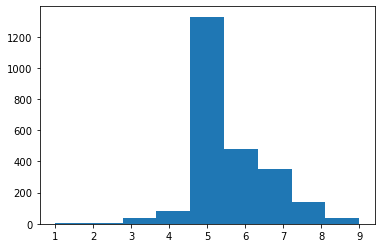

In [80]:
plt.hist(top_features['overallcond'], bins = 9)

It is interesting to find out that the overall condition of a house tend to be better in general as the house get older(positive correaltion). One reason could be there are relatively less number of houses in worse than avreage condition. The other possible explaination is when house inspectors rate the houses condition, they automatically take the 'age of house' into consideration, so the rating is given based on their knowledge about all the other houses in similar age in the area. 

In [84]:
new = merged.copy()
new.loc[new['house_age']<=new['house_age'].quantile(0.2),'new'] = 'New'
new.loc[new['house_age']>new['house_age'].quantile(0.2),'new'] = 'Not New'

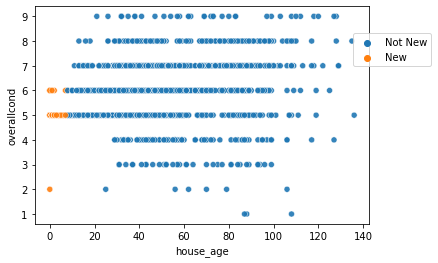

In [85]:
import seaborn as sns
# plt.figure(figsize=(12,10))
# g = sns.FacetGrid(age_cond, col="neighborhood")
sns.scatterplot(data=new, x ='house_age', y ='overallcond', hue='new',alpha=0.9)
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8))

In [86]:
new_count = new.groupby(['overallcond','new'])[['pid']].count().reset_index()

In [134]:
new_count

overallcond      new  pid
0             1  Not New    3
1             2      New    1
2             2  Not New    6
3             3  Not New   36
4             4  Not New   79
5             5      New  519
6             5  Not New  809
7             6      New    8
8             6  Not New  471
9             7  Not New  350
10            8  Not New  137
11            9  Not New   36

In [136]:
import plotly.graph_objects as go

ratings = [1,2,3,4,5,6,7,8,9,10]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=ratings,
    y=[0, 1, 0, 0, 519, 8, 0, 0, 0, 0],
    name='New House',
    marker_color='#F55E61'
))
fig.add_trace(go.Bar(
    x=ratings,
    y=[3, 6, 36, 79, 809, 471, 350, 137, 36, 0],
    name='Not New House',
    marker_color='#BEBEBE'
))
fig.update_layout(xaxis_title = 'Overall Condition', yaxis_title = 'Count',\
                title={'text': 'Inbalanced Overall Condition Rating for Newer Houses',
                        'y':0.96,
                        'x':0.5},\
    font_color = '#5e696c', plot_bgcolor = 'rgba(0,0,0,0)',paper_bgcolor = 'rgba(0,0,0,0)',bargap = 0.05
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group')
fig.show()

It seems when we separate the houses by age group(newer than 80% of all houses or not), the newer houses are receiving all similar ratings, while old housed ratings are more spread out. It proves that the rating is objective, the rater has taken the general condition of similar houses into consideration, intentionally or unintentionally. 

(array([815., 233., 498., 413., 157., 210.,  83.,  36.,  10.]),
 array([  0.        ,  15.11111111,  30.22222222,  45.33333333,
         60.44444444,  75.55555556,  90.66666667, 105.77777778,
        120.88888889, 136.        ]),
 <a list of 9 Patch objects>)

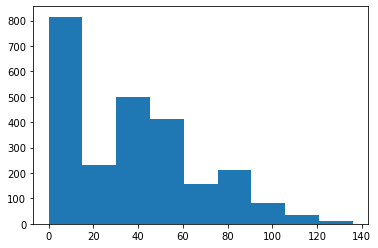

In [88]:
plt.hist(top_features['house_age'], bins = 9)

In [89]:
top_features['house_age'].describe()

count    2455.000000
mean       37.591446
std        29.493823
min         0.000000
25%         9.000000
50%        36.000000
75%        55.000000
max       136.000000
Name: house_age, dtype: float64

Even though the older houses condition are rated more evenly, we still observe more higher rating houses than lower. It is probably because the fact that our dataset only contains houses were eventually got sold. In this case, even if the house inspectors rate the house condition given the house age, it would still be harder for the older house to be sold.

#### Therefore, we would recommend the owners who having house age older than 15 should consider more about adaquate renovation, not only to increase the sale price, but to increase the chances of the house to be sold.

## Multicollinearity

In [90]:
new.new.value_counts()

Not New    1927
New         528
Name: new, dtype: int64

In [91]:
new[['grlivarea','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice']].mean()

grlivarea          1469.428921
overallqual           6.017515
overallcond           5.631365
bbratio_abvgr         1.467013
price_sqft          120.351114
fireplaces            0.595927
totalbsmtsf        1022.663544
bsmtfinsf1          429.628106
garagecars            1.736456
heatingqc             4.134420
saleprice        174027.726680
dtype: float64

In [92]:
new.groupby('new')[['grlivarea','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice','poolarea']].mean().reset_index()

new    grlivarea  overallqual  overallcond  bbratio_abvgr  price_sqft  \
0      New  1627.696970     7.306818     5.009470       1.057888  142.371853   
1  Not New  1426.063311     5.664245     5.801764       1.579113  114.317408   

   fireplaces  totalbsmtsf  bsmtfinsf1  garagecars  heatingqc      saleprice  \
0    0.647727  1244.844697  460.215909    2.272727   4.969697  229499.678030   
1    0.581733   961.785677  421.247016    1.589517   3.905553  158828.354437   

   poolarea  
0  0.000000  
1  2.150493

In [93]:
new.groupby('new')[['saleprice']].median().reset_index()

new  saleprice
0      New     214500
1  Not New     146500

In [94]:
import plotly.figure_factory as ff

new_ = new.loc[new['new']=='New']['price_sqft']
old = new.loc[new['new']=='Not New']['price_sqft']

hist_data = [new_, old]
group_labels = ['New Home', 'Not New Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)']

fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [95]:
new[new['new']=='New'].overallcond.describe()

count    528.000000
mean       5.009470
std        0.179355
min        2.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        6.000000
Name: overallcond, dtype: float64

In [133]:
import plotly.express as px


fig = px.scatter(new, y="grlivarea", x="house_age", color='overallqual', 
                 color_continuous_scale=px.colors.sequential.Agsunset)
# fig.update_layout(title_text='Multicollinearity between independent variables',
#                   plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = "House Age") 
fig.update_yaxes(title_text = "Living Area sqft",showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')
fig.update_layout(xaxis_title = 'Year', yaxis_title = 'Sale Price (log scale)',\
                title={'text': 'Multicollinearity between independent variables',
                        'y':0.96,
                        'x':0.5},\
    font_color = '#5e696c', plot_bgcolor = 'rgba(0,0,0,0)',paper_bgcolor = 'rgba(0,0,0,0)',bargap = 0.05
)
fig.show()

In [99]:
large = merged.copy()
large.loc[large['grlivarea']>=large['grlivarea'].quantile(0.8),'size'] = 'Large'
large.loc[large['grlivarea']<large['grlivarea'].quantile(0.8),'size'] = 'Not Large'

In [100]:
large.groupby('size')[['house_age','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice','poolarea']].mean().reset_index()

size  house_age  overallqual  overallcond  bbratio_abvgr  price_sqft  \
0      Large  31.467480     6.922764     5.504065       1.355399  111.942170   
1  Not Large  39.126337     5.790627     5.663271       1.494987  122.458704   

   fireplaces  totalbsmtsf  bsmtfinsf1  garagecars  heatingqc      saleprice  \
0    1.014228  1180.359756  490.359756    2.205285   4.426829  241285.280488   
1    0.491085   983.139073  414.406521    1.618951   4.061131  157170.509934   

   poolarea  
0  5.186992  
1  0.811004

In [107]:
new.groupby(['new','bsmtexposure'])['pid'].count().unstack().reset_index()

bsmtexposure      new   Av   Gd   Mn    No  No Bsmt
0                 New  135   70   49   271        3
1             Not New  196  140  153  1376       62

In [108]:
new.groupby(['new','poolqc'])['pid'].count().unstack().reset_index()

poolqc      new   Ex   Fa   Gd  No Pool   TA
0           New  NaN  NaN  NaN    528.0  NaN
1       Not New  1.0  2.0  2.0   1919.0  3.0

In Ames, the newer houses (built after 2000) are in every aspect better than the older houses. They have larger living spaces, better quality material, on average every bedroom having a bathroom, and more parking spots. Also none of the new houses have a swimming pool, while almost all of them have a basement with 3 exceptions. In fact, having a pool and not having a basement will decrease the saleprice of the house in the model, that's probably why the constructors stopped to build those type of house after 2000.